# Assignment 1: detecting offensive content on twitter
**Assignment due 1 March 2025 11:59pm**

Welcome to the first assignment for 50.055 Machine Learning Operations. These assignments give you a chance to practice the methods and tools you have learned. 

**This assignment is an individual assignment.**

- Read the instructions in this notebook carefully
- Add your solution code and answers in the appropriate places. The questions are marked as **QUESTION:**, the places where you need to add your code and text answers are marked as **ADD YOUR SOLUTION HERE**
- The completed notebook, including your added code and generated output, will be your submission for the assignment.
- The notebook should execute without errors from start to finish when you select "Restart Kernel and Run All Cells..". Please test this before submission.
- Use the SUTD Education Cluster or Google Colab to solve and test the assignment.

**Rubric for assessment** 

Your submission will be graded using the following criteria. 
1. Code executes: your code should execute without errors. The SUTD Education cluster should be used to ensure the same execution environment.
2. Correctness: the code should produce the correct result or the text answer should state the factual correct answer.
3. Style: your code should be written in a way that is clean and efficient. Your text answers should be relevant, concise and easy to understand.
4. Partial marks will be awarded for partially correct solutions.
5. There is a maximum of 76 points for this assignment.


**ChatGPT policy:** 

If you use AI tools, such as ChatGPT, to solve the assignment questions, you need to be transparent about its use and mark AI-generated content as such. In particular, you should include the following in addition to your final answer:
- A copy or screenshot of the prompt you used
- The name of the AI model
- The AI generated output
- An explanation why the answer is correct or what you had to change to arrive at the correct answer

**Assignment Notes:** Please make sure to save the notebook as you go along. Submission Instructions are located at the bottom of the notebook.


In [1]:
# Installing all required packages
# ----------------
! pip install transformers[torch]==4.37.2
! pip install evaluate==0.4.1
! pip install scikit-learn==1.4.0
! pip install datasets==2.17.1
! pip install wandb==0.16.3
! pip install seaborn==0.13.2
! pip install peft==0.10.0
! pip install accelerate==0.28.0 
# ----------------



In [2]:
# Importing all required packages
# ----------------
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn import metrics

import pandas as pd
import numpy as np
import evaluate
import time

import seaborn as sns
import matplotlib.pyplot as plt

import transformers
from transformers import AutoTokenizer
from transformers import TrainingArguments, Trainer
from datasets import load_dataset
# ----------------

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%matplotlib inline


# Offensive language detection

Content moderation of offensive or hateful language is an important task on social media platforms. 
In this assignment, you will train a text classification models for detecting offensive language on twitter. You will run experiments with different models and evaluate their performance and costs.

We will use the TweetEval data set from Barbiert et al (2020): https://aclanthology.org/2020.findings-emnlp.148.pdf


**Warning**
Some of the content contains rude and offensive language. If you know that this causes you distress, let the course instructor know to arrange a different assessment.




In [4]:
# load data set 
dataset = load_dataset("tweet_eval", "offensive")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 11916
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 860
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1324
    })
})

In [9]:
# QUESTION: print the first training set sample 

#--- ADD YOUR SOLUTION HERE (1 point)---
dataset["train"][0]
#------------------------------
# Hint: you should see a tweet about U2 singer Bono

{'text': '@user Bono... who cares. Soon people will understand that they gain nothing from following a phony celebrity. Become a Leader of your people instead or help and support your fellow countrymen.',
 'label': 0}

In [10]:
# QUESTION: what are the possible values of the labels? What is their meaning? 
# Print the set of label values and their label names
#--- ADD YOUR SOLUTION HERE (5 points) ---
values = set(dataset["train"]["label"])
print("label values -", values)

names = dataset["train"].features["label"].names
for idx, name in enumerate(names):
    print(f"{idx} - {name}")
# -------
# Hint: it is a binary task

label values - {0, 1}
0 - non-offensive
1 - offensive


<Axes: title={'center': 'Label Distribution'}, xlabel='Labels', ylabel='Counts'>

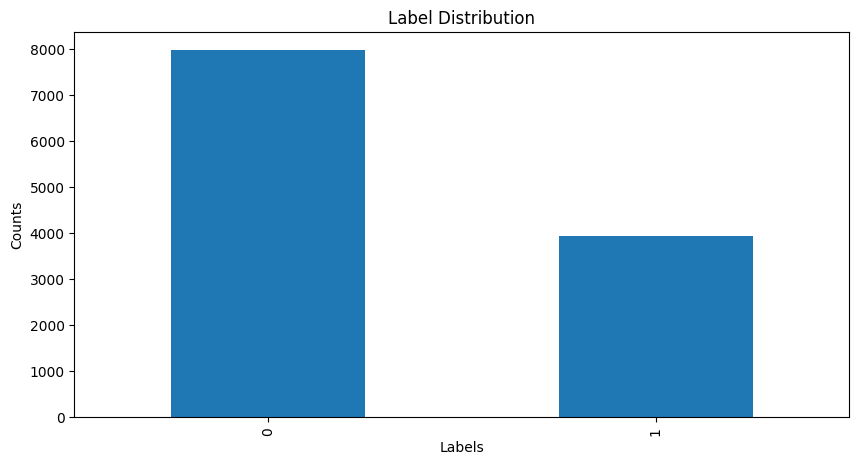

In [11]:
# QUESTION: plot a bar chart of the label distribution
#--- ADD YOUR SOLUTION HERE (5 points) ---
df = dataset['train'].to_pandas()
labels = df['label']
counts = labels.value_counts()
counts.plot(kind='bar', figsize=(10,5), title='Label Distribution', xlabel='Labels', ylabel='Counts')
#------------------------------
# Hint: it is not evenly distributed

In [12]:
# QUESTION: separate data set into training, validation and test according to given dataset split
# You should end up with the following variables
# train_text = array containing strings in training set
# train_labels = array containing numeric labels in training set
# validation_text = array containing strings in training set
# validation_labels = array containing numeric labels in training set
# test_text = array containing strings in training set
# test_labels = array containing numeric labels in training set

#--- ADD YOUR SOLUTION HERE (10 points) ---
train_text = dataset["train"]["text"]
train_labels = dataset["train"]["label"]

validation_text = dataset["validation"]["text"]
validation_labels = dataset["validation"]["label"]

test_text = dataset["test"]["text"]
test_labels = dataset["test"]["label"]
#------------------------------

In [13]:
# check the size of the data splits
print("#train: ", len(train_text)) 
print("#validation: ", len(validation_text)) 
print("#test: ", len(test_text)) 

# Hint: you should see
#train:  11916
#validation:  1324
#test:  860

#train:  11916
#validation:  1324
#test:  860


In [15]:
# 
# QUESTION: create a scikit-learn pipeline object that creates unigram features, applies tf-idf weighting and trains a SGDClassifier 
# tf-idf stands for "Term Frequency times Inverse Document Frequency".
# tf-idf is a feature weighting methods commonly used in NLP and IR
# use default parameters for unigram feature extraction, tf-idf and the SGDClassifier
# add additional import statements in this cell as needed

#--- ADD YOUR SOLUTION HERE (10 points) ---
from sklearn.feature_extraction.text import CountVectorizer  
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', SGDClassifier())
])
#------------------------------
# Hint: use the scikit-learn library

# Train the model


In [16]:
# 
# QUESTION: apply your pipeline of feature extraction and model training to the training set
# Measure the wall-clock training time needed 
# Store the training time in a variable 'train_time_sgd
#--- ADD YOUR SOLUTION HERE (5 points) ---
import time
start = time.time()
pipeline.fit(train_text, train_labels)
end = time.time()
train_time_sgd = end - start
#------------------------------

In [17]:
print(f"training time: {train_time_sgd}s")

# Hint: training should take < 1 sec

training time: 0.3645956516265869s


# Test the model


In [19]:
# 
# QUESTION: compute the majority class baseline score on the validation set and test set
# the majority class baseline is the score you get if you always predict the most frequent label
# 
# Compute the precision, recall and F1 score for the majority baseline for validation and test set for each class
#
#--- ADD YOUR SOLUTION HERE (5 points) ---
# easiest way to get the metrics is to use the classification_report since I dont need to isolate the metrics for this one
from sklearn.metrics import classification_report

class_names = ['offensive', 'non offensive']
# get the majority  class in the training set
majority_class = np.argmax(np.bincount(train_labels))
print(f"majority class: {majority_class}")

val_baseline = [majority_class] * len(validation_labels)
test_baseline = [majority_class] * len(test_labels)

print(classification_report(validation_labels, val_baseline, target_names=class_names))
print(classification_report(test_labels, test_baseline, target_names=class_names))
#------------------------------

majority class: 0
               precision    recall  f1-score   support

    offensive       0.65      1.00      0.79       865
non offensive       0.00      0.00      0.00       459

     accuracy                           0.65      1324
    macro avg       0.33      0.50      0.40      1324
 weighted avg       0.43      0.65      0.52      1324

               precision    recall  f1-score   support

    offensive       0.72      1.00      0.84       620
non offensive       0.00      0.00      0.00       240

     accuracy                           0.72       860
    macro avg       0.36      0.50      0.42       860
 weighted avg       0.52      0.72      0.60       860



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/m

In [21]:
# 
# 
# QUESTION: now use your pipeline to make predictions on validation and test set
# compute and print accuracy, precision, recall, F1 score
# 
# From now on, we are only concerned with the F1 score for the "positive" class which are the offensive tweets
# Store the test F1 score for the "positive" class in a variable 'f1_validation_sgd' and 'f1_test_sgd' for validation and test set, respectively 
#--- ADD YOUR SOLUTION HERE (10 points) ---
from sklearn.metrics import  f1_score, precision_score, recall_score, accuracy_score

# validation set
val_pred = pipeline.predict(validation_text)
val_accuracy = accuracy_score(validation_labels, val_pred)
val_precision = precision_score(validation_labels, val_pred)
val_recall = recall_score(validation_labels, val_pred)
val_f1 = f1_score(validation_labels, val_pred, pos_label=1) # added this pos_label=1 to make sure it's only for positive class

f1_val_sgd = val_f1  #  already for positive class
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision}")
print(f"Val Recall: {val_recall}")
print(f"F1 score for offensive (positive) tweets (validation): {f1_val_sgd:.4f}")

# test set
test_pred = pipeline.predict(test_text)
test_accuracy = metrics.accuracy_score(test_labels, test_pred)
test_precision = metrics.precision_score(test_labels, test_pred)
test_recall = metrics.recall_score(test_labels, test_pred)
test_f1 = metrics.f1_score(test_labels, test_pred, pos_label=1)# added this pos_label=1 to make sure it's only for positive class
f1_test_sgd = test_f1  # already for positive class
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"F1 score for offensive (positive) tweets (test): {f1_test_sgd:.4f}")
#------------------------------
# Hint: F1 scores should be >50%

Val Accuracy: 0.7621
Val Precision: 0.8050847457627118
Val Recall: 0.4139433551198257
F1 score for offensive (positive) tweets (validation): 0.5468
Test Accuracy: 0.8081
Test Precision: 0.8151260504201681
Test Recall: 0.4041666666666667
F1 score for offensive (positive) tweets (test): 0.5404


# BERT model

Now let us try a more powerful model: the DistilBERT uncased model

https://huggingface.co/distilbert-base-uncased

In [22]:
# load DistilBERT tokenizer and tokenize data set
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
train_dataset = tokenized_datasets["train"]
eval_dataset = tokenized_datasets["validation"]
test_dataset = tokenized_datasets["test"]

/opt/conda/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [23]:
# load DistilBERT model for classification

#--- ADD YOUR SOLUTION HERE (5 points) ---
from transformers import AutoModelForSequenceClassification
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Available device: ', device)
# loading the DistilBERT using AutoModelForSequenceClassification with 2 labels
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)
#------------------------------
# Hint: make sure your model corresponds to your tokenizer

Available device:  cuda


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
# add custom metrics that computes precision, recall, f1, accuracy

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    # Calculate accuracy
    accuracy = accuracy_score(labels, preds)

   # Calculate precision, recall, and F1-score
    precision = precision_score(labels, preds, average='binary')
    recall = recall_score(labels, preds, average='binary')
    f1 = f1_score(labels, preds, average='binary')
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [25]:
#
# QUESTION: configure the training parameters using the Huggingface TrainingArguments class
# - set the output directory to "finetuning-tweeteval"
# - do not report training metrics to an external experiment tracking service
# - print acc/p/r/f1 scores on the validation set every 200 steps
# - learning rate to 2e-5, 
# - set weight decay to 0.01
# - set epochs to 1


#--- ADD YOUR SOLUTION HERE (5 points) ---
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="finetuning-tweeteval",
    evaluation_strategy="steps",
    eval_steps=200,
    logging_dir="logs",
    logging_steps=200,
    learning_rate=2e-5,
    weight_decay=0.01,
    num_train_epochs=1,
    report_to="none",  # this is the do not report to any external service,
)
#------------------------------

In [26]:
# initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

/opt/conda/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [27]:
# train the model
# i'm using time here because it's consistent with the sgd (instead of extracting it from Trainer)
from time import time
start = time()
train_output = trainer.train()
end = time()
train_time_bert = end - start

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
200,0.540700,0.497089,0.747734,0.606838,0.773420,0.680077
400,0.476600,0.456010,0.795317,0.781437,0.568627,0.658260
600,0.449800,0.458876,0.810423,0.757426,0.666667,0.709154
800,0.479600,0.460969,0.793807,0.751351,0.605664,0.670688
1000,0.473000,0.432049,0.796073,0.721311,0.671024,0.695260
1200,0.438700,0.433367,0.798338,0.772727,0.592593,0.670777
1400,0.414500,0.429440,0.803625,0.750630,0.649237,0.696262


Checkpoint destination directory finetuning-tweeteval/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory finetuning-tweeteval/checkpoint-1000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


In [28]:
# Evaluate on training set
trainer.evaluate(train_dataset)

{'eval_loss': 0.36067232489585876,
 'eval_accuracy': 0.8464249748237663,
 'eval_precision': 0.7970728961441036,
 'eval_recall': 0.7185993402689672,
 'eval_f1': 0.755804643714972,
 'eval_runtime': 65.2757,
 'eval_samples_per_second': 182.549,
 'eval_steps_per_second': 22.826,
 'epoch': 1.0}

In [32]:
# Evaluate on validation set
trainer.evaluate(eval_dataset)

{'eval_loss': 0.4275238513946533,
 'eval_accuracy': 0.8066465256797583,
 'eval_precision': 0.7493857493857494,
 'eval_recall': 0.664488017429194,
 'eval_f1': 0.7043879907621247,
 'eval_runtime': 7.4462,
 'eval_samples_per_second': 177.809,
 'eval_steps_per_second': 22.293,
 'epoch': 1.0}

In [33]:
# Evaluate on test set
test_output = trainer.evaluate(test_dataset)
print(test_output)

{'eval_loss': 0.3695092797279358, 'eval_accuracy': 0.8465116279069768, 'eval_precision': 0.77, 'eval_recall': 0.6416666666666667, 'eval_f1': 0.7, 'eval_runtime': 4.8413, 'eval_samples_per_second': 177.64, 'eval_steps_per_second': 22.308, 'epoch': 1.0}


### QUESTION: 
Do you see any signs of overfitting or underfitting based on the evaluation scores
Explain why or why not

**--- ADD YOUR SOLUTION HERE (5 points) ---**

The gap between training and validation/test metrics isn't large. That's a good sign that the model generalizes well to unseen data. (This is from my experience as I don't know what a large gap is for this context)

The model also doesn't show any form of significant underfitting because if there was underfitting I would expect much lower performance on the F1 score on all datasets.

------------------------------

In [34]:
#
# QUESTION: What is the ratio f1 score to training time for the SGDClassifier and the DistilBERT model
# compute the two ratios and print them

#--- ADD YOUR SOLUTION HERE ---
ratio_sgd = f1_test_sgd / train_time_sgd
ratio_bert = test_output['eval_f1'] / train_time_bert
print(train_time_bert)

print(f"SGD ratio: {ratio_sgd:.4f}")
print(f"BERT ratio: {ratio_bert:.4f}")
print(f"\nRatio comparison (SGD/BERT): {ratio_sgd/ratio_bert}")
#------------------------------

250.2247452735901
SGD ratio: 1.4822
BERT ratio: 0.0028

Ratio comparison (SGD/BERT): 529.8195902583682


### QUESTION: 
Given the results what model would you recommend to use? Write a paragraph (max 200 words) to explain your choice

**--- ADD YOUR SOLUTION HERE (10 points)---**

I would recommend using the SGDClassifier for this offensive tweet detection task. The SGD model trains in less than a second, while still achieving really respectable performance metrics. It's an efficiency thing to consider.

For a content moderation system like such that requires frequent retraining as new data becomes available, the SGDClassifier  being able to train quickly and adapt to the new data is pretty neat. Additionally, the SGD model is much less resource-intensive during both training and inference, making it easy on the deployement side.

If absolute performance were the only consideration, DistilBERT would be preferable (especially in scenarios which require contextual understanding of the text). But, in practical MLOps scenarios, the trade-off between performance and efficiency strongly favors the SGDClassifier (Based on the ratios shown above. The SGD is about 530 times more EFFICIENT!).


------------------------------

# End

This concludes assignment 1.


Please submit this notebook with your answers and the generated output cells as a **Jupyter notebook file** via github.


1. Create a private github repository **sutd_5055mlop** under your github user.
2. Add your instructors as collaborator: ddahlmeier and lucainiaoge
3. Save your submission as assignment_01_STUDENT_NAME.ipynb where STUDENT_NAME is your name in your SUTD email address.
4. Push the submission file to your repo 
5. Submit the link to the repo via eDimensions

Example:<br/>
Email: michael_tan@mymail.sutd.edu.sg<br/>
STUDENT_NAME: michael_tan<br/>
Submission file name: assignment_01_michael_tan.ipynb



**Assignment due 01 March 2025 11:59pm**


